In [1]:
%load_ext autoreload
%autoreload 2

# 25 frames per integrations, 1 reset, integrate for 2 hours 

In [40]:
from pandorapsf import PSF, Scene, TraceScene
from pandorapsf.plotting import animate, _to_matplotlib_animation
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
from astropy.time import Time
import pandas as pd
from tqdm import tqdm

from astropy.constants import c as c_light
from astropy.io import votable
from astropy.utils.data import download_file

import os
import warnings
phoenixpath = f"/Users/chedges/repos/pandora-sat/src/pandorasat/data/phoenix"
os.environ["PYSYN_CDBS"] = phoenixpath

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Extinction files not found in ")
    # Third-party
    import pysynphot

def get_phoenix_model(teff, logg, jmag):
    logg1 = logg.value if isinstance(logg, u.Quantity) else logg
    star = pysynphot.Icat(
        "phoenix",
        teff.value if isinstance(teff, u.Quantity) else teff,
        0,
        logg1 if np.isfinite(logg1) else 5,
    )
    star_norm = star.renorm(
        jmag, "vegamag", pysynphot.ObsBandpass("johnson,j")
    )
    star_norm.convert("Micron")
    star_norm.convert("flam")

    mask = (star_norm.wave >= 0.1) * (star_norm.wave <= 3)
    wavelength = star_norm.wave[mask] * u.micron
    wavelength = wavelength.to(u.angstrom)

    sed = star_norm.flux[mask] * u.erg / u.s / u.cm**2 / u.angstrom
    return wavelength.to(u.micron), sed.to(u.erg / u.s / u.cm**2 / u.micron)

visda_pixel_scale = 0.78 * u.arcsec / u.pixel
nirda_pixel_scale = 1.19 * u.arcsec / u.pixel

visda_pixel_size = 18 * u.um / u.pixel
nirda_pixel_size = 6.5 * u.um / u.pixel

visda_frame_time = 0.2*u.second
nirda_frame_time = np.product((400, 80)) * u.pixel * (1e-5 * u.second / u.pixel)

visda_frames_per_int = 50
nirda_frames_per_int = 25

obstime = Time.now()
duration = 2*u.hour

visda_nints = int(np.ceil((duration.to(u.s)/(visda_frames_per_int * visda_frame_time)).value))
visda_nframes = visda_nints * visda_frames_per_int

nirda_nints = int(np.ceil((duration.to(u.s)/(nirda_frames_per_int * nirda_frame_time)).value))
nirda_nframes = nirda_nints * nirda_frames_per_int

In [41]:
pn = PSF.from_name("NIRDA")
pv = PSF.from_name("VISDA")

In [394]:
wavelength, spectrum = get_phoenix_model(teff=3500, logg=5.2, jmag=9)

In [400]:
unit_convert = (1 * pn.trace_wavelength.unit * spectrum.unit * pn.trace_sensitivity.unit * pn.trace_sensitivity_correction.unit).to(
    u.DN / u.second
)
bounds = np.asarray([pn.trace_wavelength - np.gradient(pn.trace_wavelength)/2, pn.trace_wavelength + np.gradient(pn.trace_wavelength)/2]).T
sensitivity = pn.trace_sensitivity * pn.trace_sensitivity_correction


nirdaflux = u.Quantity(np.zeros(len(bounds)), unit=u.DN/u.second)
for idx, bound in enumerate(bounds):
    wp = np.linspace(bound[0], bound[1], 10) * u.micron
    sens = np.interp(wp, pn.trace_wavelength.to(u.micron), sensitivity)
    spec = np.interp(wp, wavelength.to(u.micron), spectrum)
    nirdaflux[idx] = np.trapz(sens * spec, wp).to(unit_convert)

# units of electrons / second
nirdaflux = apply_gain(u.Quantity(nirdaflux, unit_convert))

In [401]:
unit_convert = (1 * pv.trace_wavelength.unit * spectrum.unit * pv.trace_sensitivity.unit * pv.trace_sensitivity_correction.unit).to(
    u.DN / u.second
)
sensitivity = pv.trace_sensitivity * pv.trace_sensitivity_correction


wp = pv.trace_wavelength 
sens = np.interp(wp, pv.trace_wavelength.to(u.micron), sensitivity)
spec = np.interp(wp, wavelength.to(u.micron), spectrum)
visdaflux = np.trapz(sens * spec, wp).to(unit_convert)

# units of electrons / second
# approximate
visdaflux = u.Quantity(visdaflux, unit_convert) * 0.6 * u.electron / u.DN

In [106]:
def find_nirda_jitter_coeff(jitter):
    """jitter in arcseconds"""
    return (jitter*u.arcsecond * 1/nirda_pixel_scale * nirda_pixel_size).value

def find_visda_jitter_coeff(jitter):
    """jitter in arcseconds"""
    return (jitter*u.arcsecond * 1/visda_pixel_scale * visda_pixel_size).value

def get_jitter(
    rowstd: float = 1,
    colstd: float = 0.5,
    correlation_time=1 * u.second,
    nframes=200,
    frame_time=0.2 * u.second,
    seed=None,
):
    time = np.arange(nframes) * frame_time  # noqa:F811
    tstd = (correlation_time / frame_time).value

    def jitter_func(std):
        f = np.random.normal(0, std, size=nframes)
        return convolve(f, Gaussian1DKernel(tstd)) * tstd**0.5

    jitter = []
    for idx, std, unit in zip(
        [0, 1], [rowstd, colstd], [u.pixel, u.pixel]
    ):
        if seed is not None:
            np.random.seed(seed + idx)
        jitter.append(jitter_func(std) * unit)

    return time, *jitter
    
def get_jitter_dfs():
    rowjitter_1sigma = 1 * u.arcsecond
    coljitter_1sigma = 1 * u.arcsecond
    jitter_timescale = 60
    
    jitter = pd.DataFrame(
        np.asarray(
            get_jitter(
                rowjitter_1sigma.value,
                coljitter_1sigma.value,
                correlation_time=jitter_timescale,
                nframes=int(((2*u.hour)/visda_frame_time.to(u.hour)).value),
                frame_time=visda_frame_time,
            )
        ).T,
        columns=["time", "rowj", "colj"],
    )
    jitter.time = (
        jitter.time * (u.second).to(u.day)
    ) + obstime.jd
    
    nirda_time = (np.arange(0, nirda_nframes) * nirda_frame_time).to(u.day).value + obstime.jd
    rowj = np.interp(nirda_time, jitter.time, jitter.rowj)
    colj = np.interp(nirda_time, jitter.time, jitter.colj)
    nirda_jitter = pd.DataFrame(np.vstack([nirda_time, rowj, colj]).T, columns=["time", "rowj", "colj"])
    visda_jitter = jitter.copy()
    # stddev of jitter is 3 arcsconds
    visda_jitter[['rowj', 'colj']] = visda_jitter[['rowj', 'colj']] * find_visda_jitter_coeff(3)
    nirda_jitter[['rowj', 'colj']] = nirda_jitter[['rowj', 'colj']] * find_jitter_coeff(3)
    return visda_jitter, nirda_jitter

In [107]:
visda_jitter, nirda_jitter = get_jitter_dfs()

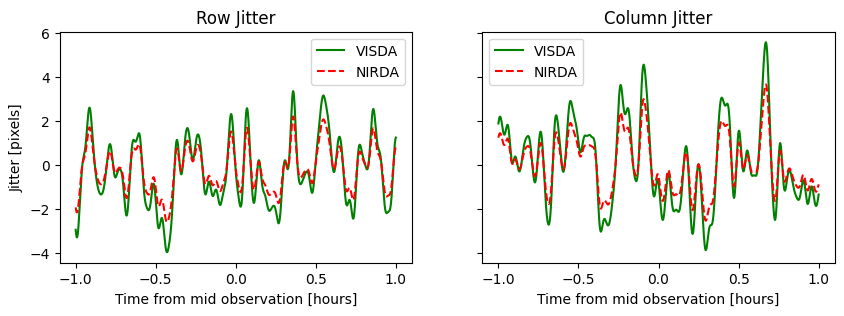

In [108]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
ax = axs[0]
ax.plot((visda_jitter.time - visda_jitter.time.mean())*u.day.to(u.hour), visda_jitter.rowj * u.micron * 1/visda_pixel_size, c='g', label='VISDA')
ax.plot((nirda_jitter.time - visda_jitter.time.mean())*u.day.to(u.hour), nirda_jitter.rowj * u.micron * 1/nirda_pixel_size, c='r', label='NIRDA', ls='--')
ax.set(title='Row Jitter', xlabel='Time from mid observation [hours]', ylabel='Jitter [pixels]')
ax.legend()
ax = axs[1]
ax.plot((visda_jitter.time - nirda_jitter.time.mean())*u.day.to(u.hour), visda_jitter.colj * u.micron * 1/visda_pixel_size, c='g', label='VISDA')
ax.plot((nirda_jitter.time - nirda_jitter.time.mean())*u.day.to(u.hour), nirda_jitter.colj * u.micron * 1/nirda_pixel_size, c='r', label='NIRDA', ls='--')
ax.set(title='Column Jitter', xlabel='Time from mid observation [hours]')
ax.legend()

## NIRDA

In [299]:
def get_background_light_estimate(shape, duration):
    """Placeholder, will estimate the background light at different locations?
    Background in one integration...!
    Sky background
    """
    # This is an approximate value assuming a zodi of ~22 Vmag
    bkg_rate = 4 * u.electron / u.second
    bkg = u.Quantity(
        np.random.poisson(
            lam=(bkg_rate * duration).to(u.electron).value * np.arange(1, shape[0] + 1)[:, None, None], size=shape
        ).astype(int),
        unit="electron",
        dtype="int",
    )

    # thermal background
    thermal_bkg = 4*u.electron/u.second
    bkg += u.Quantity(
        np.random.poisson(
            lam=(thermal_bkg * duration).to(u.electron).value * np.arange(1, shape[0] + 1)[:, None, None], size=shape
        ).astype(int),
        unit="electron",
        dtype="int",
    )    

    # Dark is this once per frame?
    dark = 0.1 * u.electron / u.second
    bkg += u.Quantity(np.random.poisson(
        lam=(dark * duration).to(u.electron).value * np.arange(1, shape[0] + 1)[:, None, None],
        size=shape,
    ).astype(int),
        unit="electron",
        dtype="int",
    )    
    return bkg


def get_noised_data(ar):
    read_noise = 8 * u.electron
    bias = 5000.
    # This needs to be run on non destructive reads (cumsum)
    
    # Shot Noise, possion process of perfect sky image
    s_bkg = np.random.poisson(lam=ar)
    # background
    s_bkg += get_background_light_estimate(ar.shape, nirda_frame_time).value

    #bias goes here?
    s_bkg += int(np.random.normal(bias, 500))
    for tdx in range(ar.shape[0]):
#       read noise every frame of the readout
        s_bkg[tdx, :, :] += np.random.normal(0, read_noise.value, size=(400, 80)).astype(int)
    s_bkg[s_bkg < 0] = 0
    return s_bkg

def fowlersample(trace, n=4):
    return (trace[-n:].sum(axis=0) - trace[:n].sum(axis=0))/n


In [169]:
locations = np.vstack([np.asarray([300]), np.asarray([40])]).T
ts = TraceScene(locations, pn)

In [305]:
pix2wav = lambda x : np.interp(x - locations[0, 0], pn.trace_pixel.value , pn.trace_wavelength.value)
wav2pix = lambda x : np.interp(x, pn.trace_wavelength.value, pn.trace_pixel.value + locations[0, 0])

In [171]:
# In electrons, one target
nirdafluxes = (nirdaflux[:, None, None] * np.asarray([1])[None, :, None] * np.ones(nirda_nframes)) * nirda_frame_time

In [377]:
nirda_nints = 10

In [378]:
integrations = np.zeros((nirda_nints, 400, 80))
for fdx in tqdm(range(nirda_nints)):
    # Drop one frame for reset
    start, stop = (25 * fdx) + 1, (25 * (fdx + 1))
    jitter_ar = (np.asarray(nirda_jitter[['rowj', 'colj']])[start:stop]).T
    ar = ts.model(nirdafluxes[:, :, start:stop], jitter_ar) 
    ar[ar <= 0] = 0
    trace = get_noised_data(np.cumsum(ar, axis=0))
    integrations[fdx, :, :] = fowlersample(trace)

100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.37it/s]


In [379]:
bkg = np.median(np.asarray([integrations[:, :, :10], integrations[:, :, -10:]]), axis=(0, 2, 3))
integrations -= bkg[:, None, None]

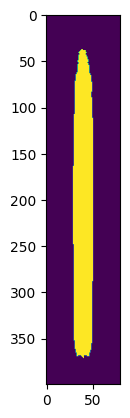

In [380]:
thumb = integrations.mean(axis=0)
thumb -= np.median(thumb)
aper = ar.sum(axis=0) > 5
plt.imshow(aper)

In [381]:
R = 30
lam = 1300 * u.nm.to(u.micron)
dy = lam/R
pixmin, pixmax = int(wav2pix((lam - dy/2))), int(wav2pix((lam + dy/2)))

In [382]:
signal = (integrations * aper)[:, pixmin:pixmax, :].sum(axis=(1, 2)).mean()

sigma = (integrations * aper)[:, pixmin:pixmax, :].sum(axis=(1, 2)).std()
noise = sigma/np.sqrt(nirda_nints)

In [383]:
f'{signal/noise} over {nirda_nints * nirda_frame_time * (nirda_frames_per_int - 1)}'

'918.7643899105059 over 76.80000000000001 s'

In [384]:
f'{np.sqrt(900/nirda_nints) * signal/noise} over {(nirda_nints * (900/nirda_nints) * nirda_frame_time * (nirda_frames_per_int - 1)).to(u.hour)}'

'8716.16431551667 over 1.92 h'

In [385]:
R, C = np.meshgrid(np.arange(400), np.arange(80), indexing='ij')
rmid = np.asarray([np.average(R, weights=integrations[tdx]) for tdx in range(nirda_nints)])
cmid = np.asarray([np.average(C, weights=integrations[tdx]) for tdx in range(nirda_nints)])

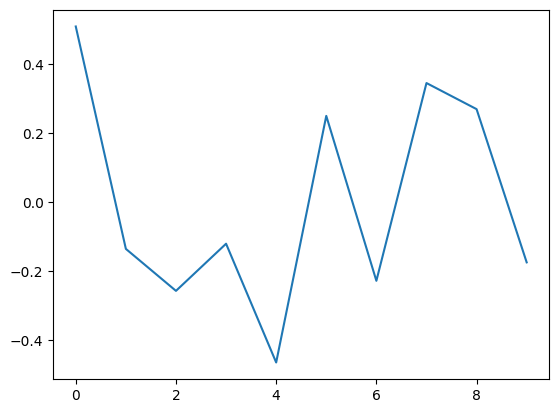

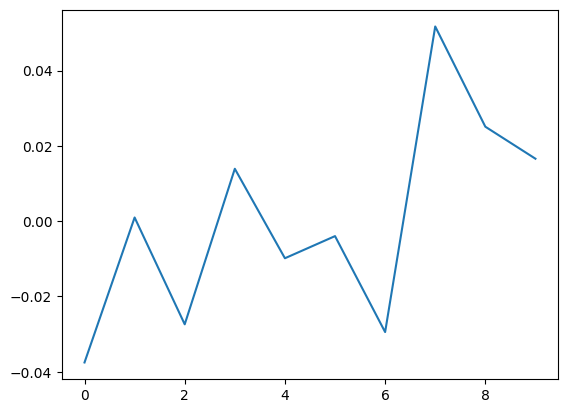

In [386]:
plt.plot((rmid - rmid.mean())*u.pixel * nirda_pixel_scale)
plt.figure()
plt.plot((cmid - cmid.mean())*u.pixel * nirda_pixel_scale)

## VISDA

In [387]:
locations = np.vstack([np.asarray([0]), np.asarray([0])]).T
s = Scene(locations, pv, shape=(50, 50), corner=(-25, 25))

In [388]:
visdafluxes = (visdaflux * visda_frame_time).value * np.ones(len(visda_jitter))[None, :]
jitter_ar = (np.asarray(visda_jitter[['rowj', 'colj']])).T

In [389]:
ar = s.model(visdafluxes, jitter_ar)

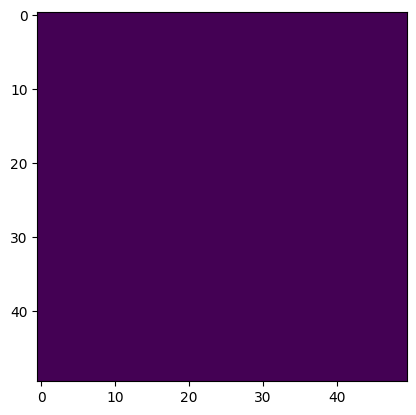

In [390]:
plt.imshow(ar[0])

In [3]:


#nframes = int(((2*u.hour)/frame_time.to(u.hour)).value)
dark = 1 * u.electron / u.second
read_noise = 8*u.electron
bias = 10.




In [4]:
def get_jitter(
    rowstd: float = 1,
    colstd: float = 0.5,
    thetastd: float = 0.0005,
    correlation_time=1 * u.second,
    nframes=200,
    frame_time=0.2 * u.second,
    seed=None,
):
    time = np.arange(nframes) * frame_time  # noqa:F811
    tstd = (correlation_time / frame_time).value

    def jitter_func(std):
        f = np.random.normal(0, std, size=nframes)
        return convolve(f, Gaussian1DKernel(tstd)) * tstd**0.5

    jitter = []
    for idx, std, unit in zip(
        [0, 1, 2], [rowstd, colstd, thetastd], [u.pixel, u.pixel, u.deg]
    ):
        if seed is not None:
            np.random.seed(seed + idx)
        jitter.append(jitter_func(std) * unit)

    return time, *jitter

def find_jitter_coeff(jitter):
    """jitter in arcseconds"""
    return (jitter*u.arcsecond * 1/nirda_pixel_scale * nirda_pixel_size).value

def find_visda_jitter_coeff(jitter):
    """jitter in arcseconds"""
    return (jitter*u.arcsecond * 1/visda_pixel_scale * visda_pixel_size).value

def fowlersample(trace, n=4):
    return (trace[-n:].sum(axis=0) - trace[:n].sum(axis=0))/n

def get_background_light_estimate(shape, duration):
    """Placeholder, will estimate the background light at different locations?
    Background in one integration...!
    Sky background
    """
    # This is an approximate value assuming a zodi of ~22 Vmag
    bkg_rate = 4 * u.electron / u.second
    bkg = u.Quantity(
        np.random.poisson(
            lam=(bkg_rate * duration).to(u.electron).value, size=shape
        ).astype(int),
        unit="electron",
        dtype="int",
    )
    return bkg

def draw_fnoise(shape):
    a = convolve(np.random.normal(0, 3, shape[0]), Gaussian1DKernel(1.5))[:, None] * np.ones(shape[1])[None, :]
    return (np.random.normal(a)).astype(int) * 10

def get_noised_data(ar):
    # Shot Noise, possion process of perfect sky image
    s_bkg = np.random.poisson(lam=ar)
    # Bias
#    s_bkg[tdx, :, :] += int(np.random.normal(bias, 1))

    for tdx in range(ar.shape[0]):
        # Sky Background
        s_bkg[tdx, :, :] += get_background_light_estimate((400, 80), frame_time).value
        
        # Dark
        s_bkg[tdx, :, :] += np.random.poisson(
            lam=(dark * frame_time).value,
            size=(400, 80),
        ).astype(int)

        # # thermal background
        # s_bkg[tdx, :, :] += np.random.poisson(
        #     lam=((4*u.electron/u.second) * frame_time).value,
        #     size=(400, 80),
        # ).astype(int)

        # # Flat field errors
        # # might be 0.5% errors in flat field
        
        # # F noise (stripy pattern)
        # # s_bkg[tdx, :, :] += draw_fnoise((400, 80))

        # # Thermal changes over the course of a frame changes the bias in each frame
        # # here we say the bias is the same in every frame for now

        # # Where's read noise?
        # s_bkg[tdx, :, :] += np.random.normal(0, read_noise.value, size=(400, 80)).astype(int)
    s_bkg[s_bkg < 0] = 0
    return s_bkg


Make a jitter dataframe

We're going to assume a jitter of ~3 arcseconds. 

The gradient of the PSF is given in units of 1/micron, this needs to be converted into something else...

In [5]:
1/visda_pixel_scale * visda_pixel_size

<Quantity 23.07692308 um / arcsec>

In [6]:
1/nirda_pixel_scale * nirda_pixel_size

<Quantity 5.46218487 um / arcsec>

This gives us a conversion so we can use the jitter

In [7]:
(3*u.arcsecond) * 1/visda_pixel_scale * visda_pixel_size

<Quantity 69.23076923 um>

In [8]:
(3*u.arcsecond) * 1/nirda_pixel_scale * nirda_pixel_size

<Quantity 16.38655462 um>

In [10]:
rowjitter_1sigma = 1 * u.arcsecond
coljitter_1sigma = 1 * u.arcsecond
thetajitter_1sigma = 0.0005 * u.deg
jitter_timescale = 60

jitter = pd.DataFrame(
    np.asarray(
        get_jitter(
            rowjitter_1sigma.value,
            coljitter_1sigma.value,
            thetajitter_1sigma.value,
            correlation_time=jitter_timescale,
            nframes=int(((2*u.hour)/visda_frame_time.to(u.hour)).value),
            frame_time=visda_frame_time,
        )
    ).T,
    columns=["time", "rowj", "colj", "thetaj"],
)
jitter.time = (
    jitter.time * (u.second).to(u.day)
) + obstime.jd

nirda_time = (np.arange(0, nframes) * frame_time).to(u.day).value + obstime.jd
rowj = np.interp(nirda_time, jitter.time, jitter.rowj)
colj = np.interp(nirda_time, jitter.time, jitter.colj)
nirda_jitter = pd.DataFrame(np.vstack([nirda_time, rowj, colj]).T, columns=["time", "rowj", "colj"])
visda_jitter = jitter.copy()
# stddev of jitter is 3 arcsconds
visda_jitter[['rowj', 'colj']] = visda_jitter[['rowj', 'colj']] * find_visda_jitter_coeff(3)
nirda_jitter[['rowj', 'colj']] = nirda_jitter[['rowj', 'colj']] * find_jitter_coeff(3)

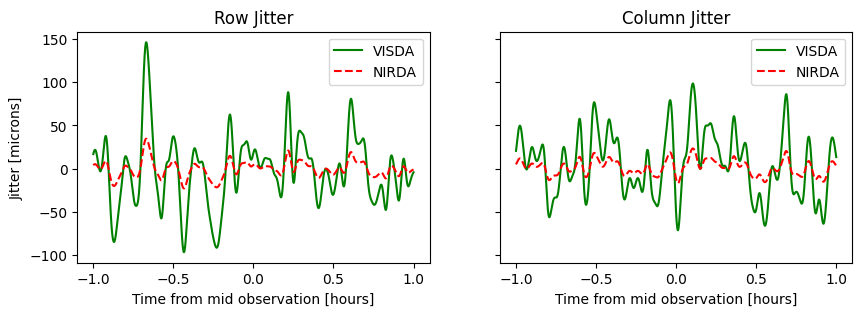

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
ax = axs[0]
ax.plot((visda_jitter.time - visda_jitter.time.mean())*u.day.to(u.hour), visda_jitter.rowj, c='g', label='VISDA')
ax.plot((nirda_jitter.time - visda_jitter.time.mean())*u.day.to(u.hour), nirda_jitter.rowj, c='r', label='NIRDA', ls='--')
ax.set(title='Row Jitter', xlabel='Time from mid observation [hours]', ylabel='Jitter [microns]')
ax.legend()
ax = axs[1]
ax.plot((visda_jitter.time - nirda_jitter.time.mean())*u.day.to(u.hour), visda_jitter.colj, c='g', label='VISDA')
ax.plot((nirda_jitter.time - nirda_jitter.time.mean())*u.day.to(u.hour), nirda_jitter.colj, c='r', label='NIRDA', ls='--')
ax.set(title='Column Jitter', xlabel='Time from mid observation [hours]')
ax.legend()

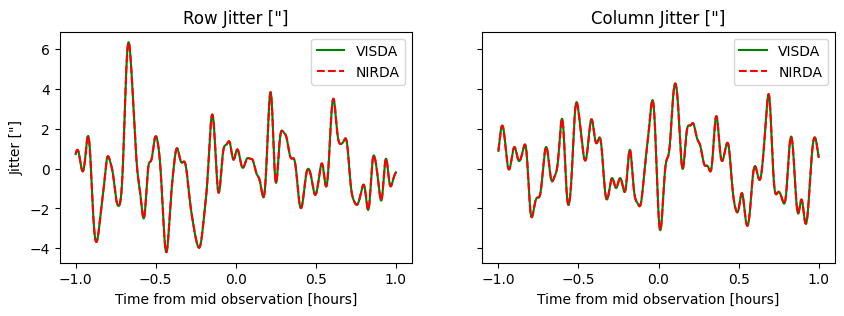

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
ax = axs[0]
ax.plot((visda_jitter.time - visda_jitter.time.mean())*u.day.to(u.hour), visda_jitter.rowj/find_visda_jitter_coeff(1), c='g', label='VISDA')
ax.plot((nirda_jitter.time - visda_jitter.time.mean())*u.day.to(u.hour), nirda_jitter.rowj/find_jitter_coeff(1), c='r', label='NIRDA', ls='--')
ax.set(title='Row Jitter ["]', xlabel='Time from mid observation [hours]', ylabel='Jitter ["]')
ax.legend()
ax = axs[1]
ax.plot((visda_jitter.time - nirda_jitter.time.mean())*u.day.to(u.hour), visda_jitter.colj/find_visda_jitter_coeff(1), c='g', label='VISDA')
ax.plot((nirda_jitter.time - nirda_jitter.time.mean())*u.day.to(u.hour), nirda_jitter.colj/find_jitter_coeff(1), c='r', label='NIRDA', ls='--')
ax.set(title='Column Jitter ["]', xlabel='Time from mid observation [hours]')
ax.legend()

Load the NIRDA PSF

In [13]:
p = PSF.from_name("nirda")

Build a spectrum for the star

In [14]:
wavelength, spectrum = get_phoenix_model(teff=3500, logg=5.2, jmag=9)
# SED = _get_SED('TRAPPIST-1')

In [15]:
# plt.plot(wavelength, spectrum.to(SED['sed_flux'].unit), c='grey', label='PHOENIX')
# plt.scatter(SED['wavelength'].to(u.micron), SED['sed_flux'], c='k', zorder=10, label='SED')
# plt.legend()

In [16]:
unit_convert = (1 * p.trace_wavelength.unit * spectrum.unit * p.trace_sensitivity.unit * p.trace_sensitivity_correction.unit).to(
    u.DN / u.second
)
bounds = np.asarray([p.trace_wavelength - np.gradient(p.trace_wavelength)/2, p.trace_wavelength + np.gradient(p.trace_wavelength)/2]).T
sensitivity = p.trace_sensitivity * p.trace_sensitivity_correction


integral = u.Quantity(np.zeros(len(bounds)), unit=u.DN/u.second)
for idx, bound in enumerate(bounds):
    wp = np.linspace(bound[0], bound[1], 10) * u.micron
    sens = np.interp(wp, p.trace_wavelength.to(u.micron), sensitivity)
    spec = np.interp(wp, wavelength.to(u.micron), spectrum)
    integral[idx] = np.trapz(sens * spec, wp).to(unit_convert)

# units of electrons / second
integral = apply_gain(u.Quantity(integral, unit_convert))

In [17]:
# SED['sed_flux_sens'] = apply_gain(spectrum.to(SED['sed_flux'].unit) * np.interp(wavelength.to(u.micron), p.trace_wavelength.to(u.micron),  sensitivity))

In [18]:
# np.trapz(SED['sed_flux_sens'], wavelength).to(u.electron/u.second)

In [19]:
integral.sum()

<Quantity 155104.8772727 electron / s>

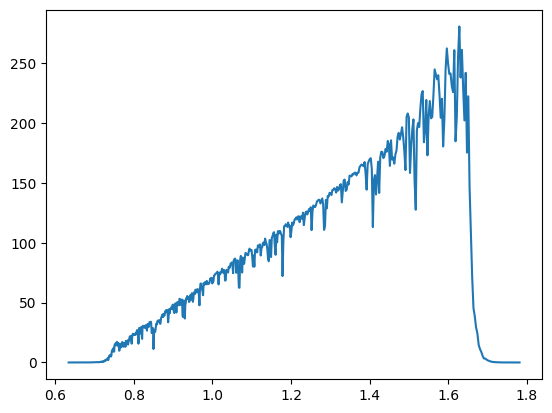

In [20]:
plt.plot(p.trace_wavelength, integral*frame_time)

Create a wavelength dispersed trace object

In [21]:
locations = np.vstack([np.asarray([300]), np.asarray([40])]).T
ts = TraceScene(locations, p)

In [22]:
pix2wav = lambda x : np.interp(x - locations[0, 0], p.trace_pixel.value , p.trace_wavelength.value)
wav2pix = lambda x : np.interp(x, p.trace_wavelength.value, p.trace_pixel.value + locations[0, 0])

In [23]:
ts.X.dot(integral).sum() # electrons per second

155086.1240621224

Make a matrix of spectra for the target(s) over time

In [24]:
# In electrons
spectra = (integral[:, None, None] * np.asarray([1])[None, :, None] * np.ones(nframes)) * frame_time

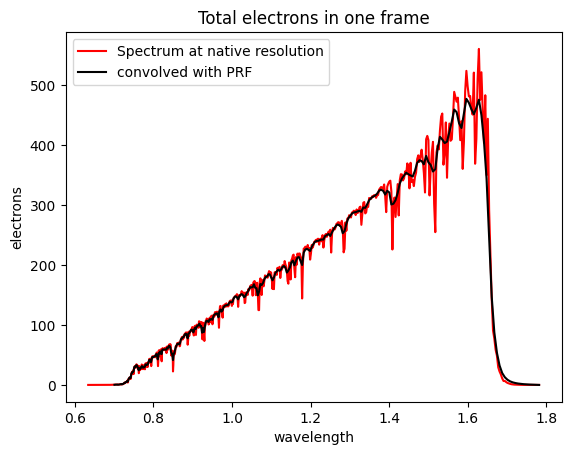

In [25]:
plt.plot(p.trace_wavelength, integral*frame_time / 0.5, c='r', label='Spectrum at native resolution')
plt.plot(pix2wav(np.arange(400)), ts.model(spectra[:, :, 0].value)[0].sum(axis=1), c='k', label='convolved with PRF')
plt.title('Total electrons in one frame')
plt.xlabel('wavelength')
plt.ylabel('electrons')
plt.legend()

In [26]:
ts.model(spectra[:, :, 0]).sum()*u.electron / frame_time

<Quantity 155086.12406212 electron / s>

## No Jitter

In [386]:
def get_background_light_estimate(shape, duration):
    """Placeholder, will estimate the background light at different locations?
    Background in one integration...!
    Sky background
    """
    # This is an approximate value assuming a zodi of ~22 Vmag
    bkg_rate = 4 * u.electron / u.second
    bkg = u.Quantity(
        np.random.poisson(
            lam=(bkg_rate * duration).to(u.electron).value * np.arange(1, shape[0] + 1)[:, None, None], size=shape
        ).astype(int),
        unit="electron",
        dtype="int",
    )

    # thermal background
    thermal_bkg = 4*u.electron/u.second
    bkg += u.Quantity(
        np.random.poisson(
            lam=(thermal_bkg * duration).to(u.electron).value * np.arange(1, shape[0] + 1)[:, None, None], size=shape
        ).astype(int),
        unit="electron",
        dtype="int",
    )    
    return bkg


def get_noised_data(ar):
    # This needs to be run on non destructive reads (cumsum)
    
    # Shot Noise, possion process of perfect sky image
    s_bkg = np.random.poisson(lam=ar)
    # background
    s_bkg += get_background_light_estimate(ar.shape, frame_time).value

    #bias goes here?
    s_bkg += int(np.random.normal(bias, 1))
    for tdx in range(ar.shape[0]):
        # Dark is this once per frame?
        s_bkg[tdx, :, :] += np.random.poisson(
            lam=(dark * frame_time).value,
            size=(400, 80),
        ).astype(int)
#       read noise every frame of the readout
        s_bkg[tdx, :, :] += np.random.normal(0, read_noise.value, size=(400, 80)).astype(int)
    s_bkg[s_bkg < 0] = 0
    return s_bkg


In [502]:
nints = 900
integrations = np.zeros((nints, 400, 80))
time = np.zeros(nints) 
for fdx in tqdm(range(nints)):
    start, stop = (25 * fdx) + 1, (25 * (fdx + 1))
    ar = ts.model(spectra[:, :, start:stop])
    trace = get_noised_data(np.cumsum(ar, axis=0))
    # bias
    integrations[fdx, :, :] = trace[-1]
    integrations[fdx, :, :] = fowlersample(trace)
    time[fdx] = jitter['time'][start:stop].mean() # This might be a bit bad I need to think about it

100%|█████████████████████████████████████████| 900/900 [02:19<00:00,  6.45it/s]


In [503]:
(ar[0]*u.electron/frame_time).sum()

<Quantity 155086.12406212 electron / s>

In [504]:
bkg = np.median(np.asarray([integrations[:, :, :10], integrations[:, :, -10:]]), axis=(0, 2, 3))
integrations -= bkg[:, None, None]

In [505]:
(integrations[0] * u.electron).sum() / ((frames_per_int - 1 - 4) * frame_time)

<Quantity 154650.8203125 electron / s>

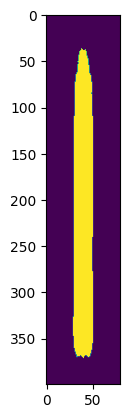

In [506]:
thumb = integrations.mean(axis=0)
thumb -= np.median(thumb)
aper = ar.sum(axis=0) > 5
plt.imshow(aper)

In [507]:
(integrations[0] * aper * u.electron).sum() / ((frames_per_int - 1 - 4) * frame_time)

<Quantity 153510.3515625 electron / s>

We need SNR of 6000 in integration of 2 hours at wavelength of 1300nm with an effective resolution of 30 for 9th magnitude star

In [508]:
pix2wav = lambda x : np.interp(x - locations[0, 0], p.trace_pixel.value , p.trace_wavelength.value)
wav2pix = lambda x : np.interp(x, p.trace_wavelength.value, p.trace_pixel.value + locations[0, 0])

In [509]:
R = 30
lam = 1300 * u.nm.to(u.micron)
dy = lam/R
pixmin, pixmax = int(wav2pix((lam - dy/2))), int(wav2pix((lam + dy/2)))

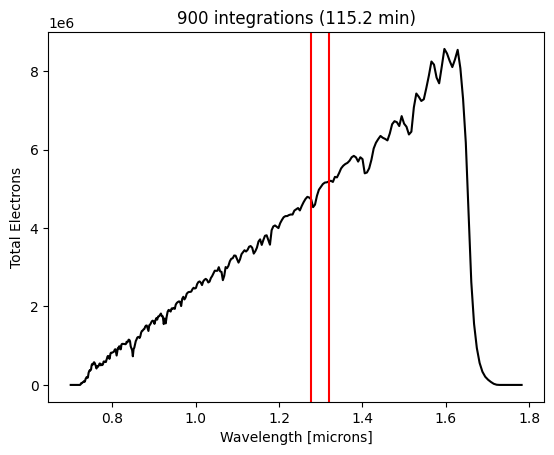

In [510]:
fig, ax = plt.subplots()
ax.plot(pix2wav(np.arange(400)), ((integrations) * aper).sum(axis=(0, 2)), c='k');
ax.set(xlabel='Wavelength [microns]', ylabel=f'Total Electrons', title=f'{nints} integrations ({(nints * 24 * frame_time).to(u.minute)})')
ax.axvline(pix2wav(pixmin), c='r')
ax.axvline(pix2wav(pixmax), c='r')

In [511]:
# fig, ax = plt.subplots()
# ax.plot(p.trace_wavelength, integral*(24*frame_time*nints), c='r', label=f'Native resolution for {nints} integrations')
# ax.plot(pix2wav(np.arange(400)), ((integrations) * aper).sum(axis=(0, 2)), c='k', label=f'Summed simulations');
# ax.set(xlabel='Wavelength [microns]', ylabel=f'Total Electrons', title=f'{nints} integrations ({(nints * 24 * frame_time).to(u.minute)})')
# ax.axvline(pix2wav(pixmin), c='r')
# ax.axvline(pix2wav(pixmax), c='r')
# ax.legend()

In [512]:
signal = (integrations * aper)[:, pixmin:pixmax, :].sum(axis=(1, 2)).mean()

sigma = (integrations * aper)[:, pixmin:pixmax, :].sum(axis=(1, 2)).std()
noise = sigma/np.sqrt(nints)

In [513]:
print(f'SNR: {signal/noise}')

SNR: 9465.388022871908


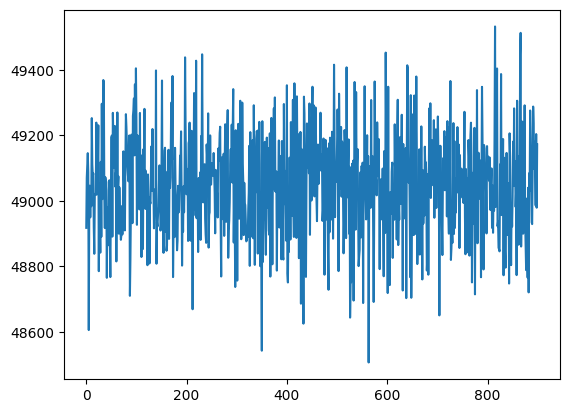

In [514]:
plt.plot((integrations * aper)[:, pixmin:pixmax, :].sum(axis=(1, 2)))

## With Jitter

In [ ]:
integrationsj = np.zeros((nints, 400, 80))
for fdx in tqdm(range(nints)):
    start, stop = (25 * fdx) + 1, (25 * (fdx + 1))
#    jitter_ar = np.random.normal(0, 1, size=(2, 24)) * 10
    jitter_ar = (np.asarray(nirda_jitter[['rowj', 'colj']])[start:stop]).T
    ar = ts.model(spectra[:, :, start:stop], jitter_ar) 
    ar[ar <= 0] = 0
    trace = get_noised_data(np.cumsum(ar, axis=0))
    integrationsj[fdx, :, :] = fowlersample(trace)

 92%|█████████████████████████████████████▌   | 825/900 [04:06<00:23,  3.24it/s]

In [ ]:
(ar[0]*u.electron/frame_time).sum()

In [ ]:
bkg = np.median(np.asarray([integrationsj[:, :, :10], integrationsj[:, :, -10:]]), axis=(0, 2, 3))
integrationsj -= bkg[:, None, None]

In [ ]:
(integrationsj[0] * u.electron).sum() / ((frames_per_int - 1 - 4) * frame_time)

In [ ]:
fig, ax = plt.subplots()
ax.plot(pix2wav(np.arange(400)), ((integrationsj) * aper).sum(axis=(0, 2)), c='k');
ax.set(xlabel='Wavelength [microns]', ylabel=f'Total Electrons', title=f'{nints} integrations ({(nints * 24 * frame_time).to(u.minute)})')
ax.axvline(pix2wav(pixmin), c='r')
ax.axvline(pix2wav(pixmax), c='r')

In [ ]:
signal = (integrationsj * aper)[:, pixmin:pixmax, :].sum(axis=(1, 2)).mean()

sigma = (integrationsj * aper)[:, pixmin:pixmax, :].sum(axis=(1, 2)).std()
noise = sigma/np.sqrt(nints)

In [ ]:
print(f'SNR: {signal/noise}')

In [ ]:
plt.imshow((integrationsj * aper).sum(axis=(2)) - (integrations * aper).sum(axis=(2)))

In [ ]:
R, C = np.meshgrid(np.arange(400), np.arange(80), indexing='ij')
rmid = np.asarray([np.average(R, weights=integrationsj[tdx]) for tdx in range(nints)])
cmid = np.asarray([np.average(C, weights=integrationsj[tdx]) for tdx in range(nints)])

In [ ]:
plt.plot((rmid - rmid.mean())*u.pixel * nirda_pixel_scale)
#plt.plot(np.asarray(nirda_jitter.rowj)[::25][:nints]/find_jitter_coeff(1))
plt.figure()
plt.plot((cmid - cmid.mean())*u.pixel * nirda_pixel_scale)
#plt.plot(np.asarray(nirda_jitter.colj)[::25][:nints]/find_jitter_coeff(1))

In [ ]:
animate(integrationsj, instance_name="Integration", step=20, vmin=0, vmax=300)

In [ ]:
from astropy.io import fits

In [ ]:
# package no jitter
# package with jitter

(2.0, 10.0)

In [501]:
from matplotlib import animation
FFwriter = animation.FFMpegWriter(fps=10)
anim = _to_matplotlib_animation(integrationsj, instance_name="Integration", step=1, figsize=(4, 10), vmin=0, vmax=300)
anim.save('test.mp4', writer=FFwriter)

In [215]:
start, stop = 1, 25
jitter_ar = np.random.normal(0, 1, size=(2, 24)) * 10
ar = ts.model(spectra[:, :, start:stop])
arj = ts.model(spectra[:, :, start:stop], jitter_ar) 
animate((arj)[:, :, :], step=1, figsize=(4, 10))

In [232]:
jitter_ar

array([[  2.8569435 ,   3.86958195, -10.40604065,   5.70567195,
          7.00695364, -13.10169762,   6.10984761,   6.16552017,
         -2.38268647,   0.59025401,  -5.0596306 ,   0.27511058,
          3.19364947,  13.11709935,  -5.82306645,   4.44744684,
          5.93053224,  -0.33563272,  -2.18547143,  25.63596515,
          6.19534745,   8.65246721,  13.95988088,   4.22611256],
       [ -4.18722115,  -6.39731634,   9.80473417, -11.50773169,
         21.56295647,   6.20719044,  11.99800597,  -3.60434477,
         -1.27558707,   0.72617264,  13.61575731,   2.44836452,
        -17.29239599,   2.64013359,   3.68615028, -16.97789582,
          1.82147681,  10.28180496,  17.82663364,   5.94955413,
          2.15203171,  -2.11985304,   1.13001965,  -7.29800621]])

In [202]:
R, C =np.meshgrid(np.arange(400), np.arange(80), indexing='ij')

In [203]:
rmid = np.asarray([np.average(R, weights=arj[tdx]) for tdx in range(24)])
cmid = np.asarray([np.average(C, weights=arj[tdx]) for tdx in range(24)])

In [212]:
(jitter_ar[0, :]/find_jitter_coeff(10*u.arcsecond))

array([ 0.01547326, -0.18047075,  0.28611781,  0.0238873 , -0.0436781 ,
       -0.18387951, -0.01820705, -0.075534  , -0.1952413 ,  0.21425585,
       -0.15420874, -0.13592806,  0.20462897, -0.13080061,  0.03677667,
        0.18323358,  0.27399595, -0.18255502, -0.0214259 ,  0.38203654,
        0.2286228 , -0.24479584,  0.04296197,  0.10948517])

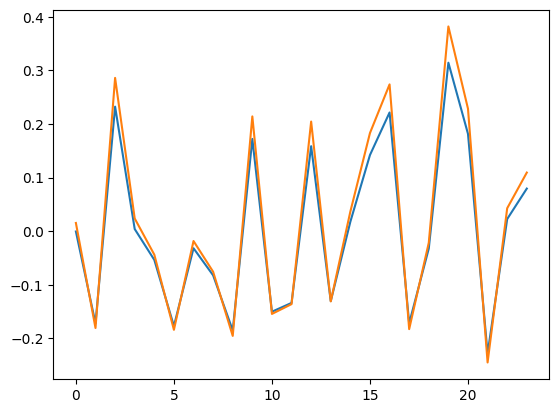

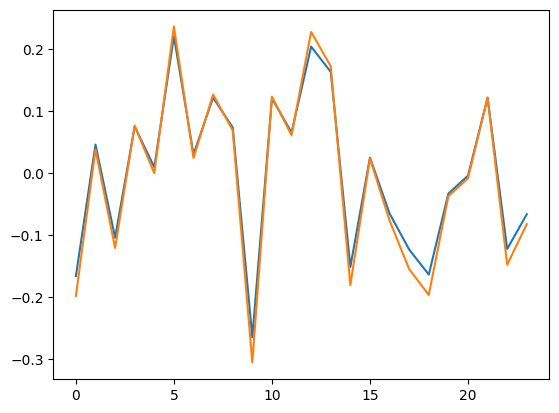

In [206]:
plt.plot(-(rmid - rmid.mean()))
plt.plot(jitter_ar[0, :]/find_jitter_coeff(10*u.arcsecond))
plt.figure()
plt.plot(-(cmid - cmid.mean()))
plt.plot(jitter_ar[1, :]/find_jitter_coeff(10*u.arcsecond))

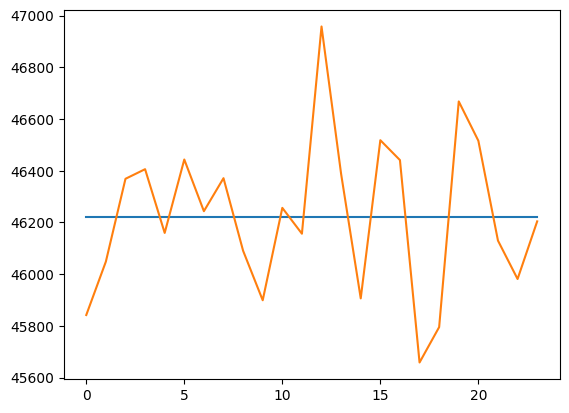

In [209]:
plt.plot((ar[:, :, :] * aper).sum(axis=(1, 2)))
plt.plot((arj[:, :, :] * aper).sum(axis=(1, 2)))

In [369]:
integrations = np.zeros((nints, 400, 80))
time = np.zeros(nints) 
for fdx in tqdm(range(nints)):
    start, stop = (25 * fdx) + 1, (25 * (fdx + 1))
    ar = ts.model(spectra[:, :, start:stop], (np.asarray(jitter[['rowj', 'colj']])[start:stop]).T) * frame_time.value
    trace = np.cumsum(get_noised_data(ar), axis=0)
    integrations[fdx, :, :] = fowlersample(trace)
    time[fdx] = jitter['time'][start:stop].mean() # This might be a bit bad I need to think about it
# Bias from the frames in between the samples?
integrations -= ((frames_per_int - 1) - 4) * 1000

100%|███████████████████████████████████████████| 50/50 [00:13<00:00,  3.75it/s]


In [374]:
np.vstack(integrations[:, :, :10]).shape

(20000, 10)

In [376]:
#bkg = np.median(np.asarray([integrations[:, :, :10], integrations[:, :, -10:]]), axis=(0, 2, 3))

[Text(0.5, 0, 'Wavelength [microns]'),
 Text(0, 0.5, 'Electrons per integration')]

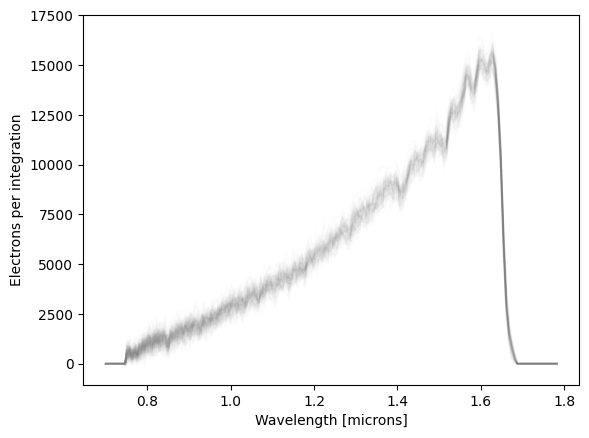

In [449]:
fig, ax = plt.subplots()
ax.plot(pix2wav(np.arange(400)), ((integrations) * aper).sum(axis=2).T, c='k', alpha=0.01);
ax.set(xlabel='Wavelength [microns]', ylabel='Electrons per integration')

SNR of 6000 in integration of 2 hours at wavelength of 1300nm with an effective resolution of 30 for 9th magnitude star

In [389]:
(100 * 24 * frame_time).to(u.minute)

<Quantity 12.8 min>

In [426]:
R = 30
lam = 1300 * u.nm.to(u.micron)
dy = lam/R

In [431]:
lam - dy/2

1.2783333333333333

In [447]:
noise = (integrations * aper)[:, int(wav2pix((lam - dy/2))):int(wav2pix((lam + dy/2))), :].sum(axis=(1, 2)).std(axis=0)
noise /= np.sqrt(nints)
signal = (integrations * aper)[:, int(wav2pix((lam - dy/2))):int(wav2pix((lam + dy/2))), :].sum(axis=(1, 2)).sum(axis=0)

In [448]:
signal/noise

7539.813732521288

In [106]:
# plt.plot(noise)

/var/folders/bv/0t7fjlgx0mx3_3bdhxqzd7bmh_67k0/T/ipykernel_23378/2234815730.py:1: RuntimeWarning: invalid value encountered in divide
  snr = signal/noise


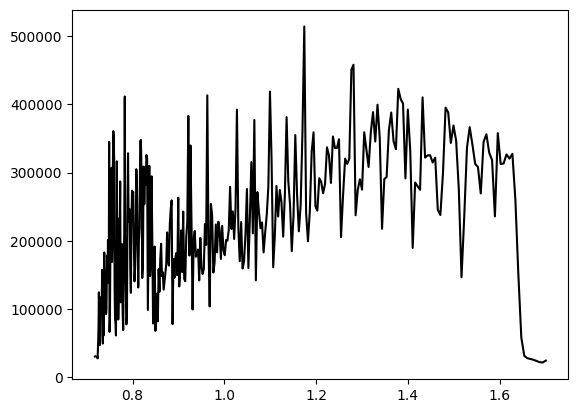

In [107]:
snr = signal/noise
plt.plot(pix2wav(np.arange(400)), snr, c='k');
#plt.ylim(-100000, 100000)